In [105]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [106]:
# hidden layer number
degree = 25
# variance
sigma = 1.
# randomized center between [-10,10]
#np.random.seed(13)
#centers = np.random.random(size=(degree, 2)) * 10 - 5
center_l = []
for i in range(0, 20, 4):
    for j in range(0, 20, 4):
        center_l.append([i-10, j-10])
centers = np.array(center_l)

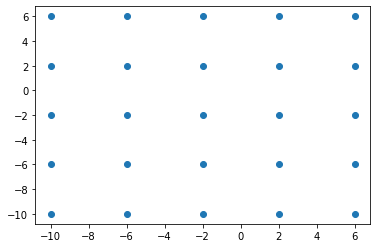

In [107]:
plt.scatter(centers[:,0], centers[:,1])

In [108]:
def kernel_func(center, data_point):
    # gaussian kernel function
    result = np.exp( -sigma * np.linalg.norm(center-data_point, axis=1) **2 )
    return result / np.sum(result)

# manipulator

In [109]:
def cal_H(theta2):
    c2 = np.cos(theta2)
    H = np.array([[1/3*m1*l1*l1+m2*l1*l1+1/3*m2*l2*l2+m2*l1*l2*c2, 1/3*m2*l2*l2+0.5*m2*l1*l2*c2],
                 [1/3*m2*l2*l2+1/2*m2*l1*l2*c2, 1/3*m2*l2*l2]])
    return H

In [110]:
def cal_C(q1_dot, q2_dot, theta2):
    c2 = np.cos(theta2)
    s2 = np.sin(theta2)
    h = -0.5*m2*l1*l2*s2
    C = np.array([[h*q2_dot, h*(q1_dot+q2_dot)],
                 [-h*q1_dot, 0]])
    return C

In [111]:
def cal_G(theta1, theta2):
    c1 = np.cos(theta1)
    c2 = np.cos(theta2)
    c12 = np.cos(theta1+theta2)
    g = 9.8
    G = np.array([[0.5*m1*g*l1*c1+m2*g*l1*c1+0.5*m2*g*l2*c12],
                 [0.5*m2*g*l2*c12]])
    return G

# initialization

In [112]:
q1_dot_list = []
q2_dot_list = []
q1_list = []
q2_list = []
torque1_list = []
torque2_list = []
s1 = []
s2 = []
time_list = []
error_list = []
s1_rl_list = []
s2_rl_list = []
critic_l = []

# param
m1 = 1
m2 = 2
l1 = 2
l2 = 2
g = 9.8


# state
q = np.array([[0.01], [0.01]], dtype=np.float32)
q_dot = np.array([[0], [0]], dtype=np.float32)
q_dot_dot = np.array([[0], [0]], dtype=np.float32)

# target
q_d = np.array([[1], [2]], dtype=np.float32)
q_d_d = np.array([[0], [0]], dtype=np.float32)
q_d_dd= np.array([[0], [0]], dtype=np.float32)



# perturbance estimation
F_est = 0
F_est_dot = 0
gama = 10
F_ = 1

c1 = 2
g = 1.8
p = 0.8

# time interval
del_t = 0.001


############ RL param ##############
Wck = np.ones((degree, 1)) * 0.1
Wak = np.ones((degree, 1)) * 0.1
Gk = np.zeros((degree, 1))
rk = 0

Pk = np.random.random((degree, 1))
Pk = np.ones((degree, 1)) * 0
mu = 0.5
beta = 0.5
ka = 0.001
#lr_c = 0.08
#lr_a = 0.4
lr_c = 0.08
lr_a = 0.3

epsilon = 0.1
yak = 0
psi_c_prev = np.zeros((degree, 1))
psi_a_prev = np.zeros((degree, 1))
psi_c = np.zeros((degree, 1))
psi_a = np.zeros((degree, 1))

###### 2nd dof #######
Wck_ = np.ones((degree, 1)) * 0.1
Wak_ = np.ones((degree, 1)) * 0.1
Gk_ = np.zeros((degree, 1))
rk_ = 0

Pk_ = np.random.random((degree, 1))
Pk_ = np.ones((degree, 1)) * 0

epsilon_ = 0.1
yak_ = 0
psi_c_prev_ = np.zeros((degree, 1))
psi_a_prev_ = np.zeros((degree, 1))
psi_c_ = np.zeros((degree, 1))
psi_a_ = np.zeros((degree, 1))

# record last step
psi_c_l = [psi_c, psi_c]
psi_a_l = [psi_a, psi_c]
rk_l = [rk, rk]
Wck_l = [Wck, Wck]
Wak_l = [Wak, Wak]

psi_c_l_ = [psi_c_, psi_c_]
psi_a_l_ = [psi_a_, psi_c_]  
rk_l_ = [rk_, rk_]
Wck_l_ = [Wck_, Wck_]
Wak_l_ = [Wak_, Wak_]

In [113]:
for i in range(15000):
    
    time_list.append(i * del_t)
    
    
    # 正弦目标
    q_d = np.ones((2,1))
    q_d[0][0] *= np.sin(2*i*del_t)
    q_d[1][0] *= np.sin(3*i*del_t)
    q_d_d = np.ones((2,1))
    q_d_d[0][0] *= 2 * np.cos(2*i*del_t)
    q_d_d[1][0] *= 3 * np.cos(3*i*del_t)
    q_d_dd = - np.ones((2,1))
    q_d_dd[0][0] *= 4 * np.sin(2*i*del_t)
    q_d_dd[1][0] *= 9 * np.sin(3*i*del_t)
    
    
    
    
    z1_dot = q_dot - q_d_d
    z1 = q - q_d
    z2 = q_dot + c1 * z1 - q_d_d

    delt_u = 1
    ###########   1DOF   #################
    '''RL'''
    
    # update
    # s = z1_dot + 10 * z1
    # s = z2 + np.sign(z1) * abs(z1) ** g
    s = (z1_dot + 6 * z1) / 2
    
    # RBF network result
    psi_c = kernel_func(centers, s.T).reshape((-1,1))
    psi_a = kernel_func(centers, s.T).reshape((-1,1))
    
    # rk and TD error update
    if(abs(s[0][0])<0.5):
        rk = -(1 / (1+np.exp(-(s[0][0]))) - 0.5) * 1000
    else:
        rk = -(1 / (1+np.exp(-(s[0][0]))) - 0.5) * 50
    
    # rk = -s[0][0] * 5
    tde = rk + beta * Wck.T.dot(psi_c) - Wck.T.dot(psi_c_l[-1])

    Q_prev = Wck.T.dot(psi_c_l[-1])
    
    #Wck = Wck - lr_c*psi_c_l[-1].dot( (Q_prev+beta**(i+1)*rk_l[-1]-0.5* Wck_l[-2].T.dot(psi_c_l[-2]).T ) )
    
    #Gk = Pk.dot(np.linalg.inv(mu + (psi_c_l[-1].T - beta*psi_c.T).dot(Pk)))
    #Pk = (Pk - Gk.dot(psi_c_l[-1].T - beta*psi_c.T).dot(Pk)) / mu
    #Wck = Wck + Gk.dot(rk_l[-1] + (psi_c_l[-1].T - beta*psi_c.T).dot(Wck))
    
    Wck = Wck + lr_c*tde*psi_c_l[-1]
    
    #Wck = Wck - lr_c * tde * (psi_c_l[-1] - beta*psi_c)
    
    Wak = Wak + lr_a*tde*psi_a_l[-1]
    
    
    yak = psi_a_l[-1].T.dot(Wak_l[-1])
    
    # print(yak)
    # print(rk_l[-1] + (psi_c_l[-1].T - gama_*psi_c.T).dot(Wck))
    # print(rk)
    critic_l.append(float(Q_prev))
    
    # record last step
    psi_c_l.append(psi_c)
    psi_a_l.append(psi_a)
    rk_l.append(rk)
    Wck_l.append(Wck)
    Wak_l.append(Wak)
    del(psi_c_l[0])
    del(psi_a_l[0])
    del(rk_l[0])
    del(Wck_l[0])
    del(Wak_l[0])
    
    #############   2DOF   ##############################
    #s = z2 + np.sign(z1) * abs(z1) ** g
    # s = z1_dot + 10 * z1

    psi_c_ = kernel_func(centers, s.T).reshape((-1,1))
    psi_a_ = kernel_func(centers, s.T).reshape((-1,1))
    
    if(abs(s[1][0])<0.5):
        rk_ = -(1 / (1+np.exp(-(s[1][0]))) - 0.5) * 1000
    else:
        rk_ = -(1 / (1+np.exp(-(s[1][0]))) - 0.5) * 50
    # rk_ = -s[1][0] * 5
    tde_ = rk_ + beta * Wck_.T.dot(psi_c_) - Wck_.T.dot(psi_c_l_[-1])

    Q_prev_ = Wck_.T.dot(psi_c_l_[-1])
    
    #Wck_ = Wck_ - lr_c*psi_c_l_[-1].dot( (Q_prev_+beta**(i+1)*rk_l_[-1]-0.5* Wck_l_[-2].T.dot(psi_c_l_[-2]).T ) )
    
    #Gk_ = Pk_.dot(np.linalg.inv(mu + (psi_c_l_[-1].T - beta*psi_c_.T).dot(Pk_)))
    #Pk_ = (Pk_ - Gk_.dot(psi_c_l_[-1].T - beta*psi_c_.T).dot(Pk_)) / mu
    #Wck_ = Wck_ + Gk_.dot(rk_l_[-1] + (psi_c_l_[-1].T - beta*psi_c_.T).dot(Wck_))
    
    Wck_ = Wck_ + lr_c*tde_*psi_c_l_[-1]
    
    # Wck_ = Wck_ - lr_c * tde_ * (psi_c_l[-1] - beta*psi_c)
    
    Wak_ = Wak_ + lr_a * tde_ *psi_a_l_[-1]
    
    yak_ = psi_a_l_[-1].T.dot(Wak_l_[-1])
    
    
    
    #print(yak)
    #print(rk)
    #print(Q_prev_)
    #print(rk)
    
    
    # record last step
    psi_c_l_.append(psi_c_)
    psi_a_l_.append(psi_a_)
    rk_l_.append(rk_)
    Wck_l_.append(Wck_)
    Wak_l_.append(Wak_)
    del(psi_c_l_[0])
    del(psi_a_l_[0])
    del(rk_l_[0])
    del(Wck_l_[0])
    del(Wak_l_[0])

    
    ############### finite time control ############################
    s = z2 + np.sign(z1) * abs(z1) ** g
    # control law
    torque = cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot) + cal_G(q[0][0], q[1][0]) + cal_H(q[1][0]).dot(- c1*z1_dot + q_d_dd - g*abs(z1)**(g-1)*(z2-c1*z1) -0.5*np.sign(s)*abs(s)**p)
    
    torque[0][0] += yak
    torque[1][0] += yak_
    
    torque_a = torque - cal_G(q[0][0], q[1][0]) - cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot)
    
    #torque_a[0][0] = yak
    #torque_a[1][0] = yak_
    
    # 随机扰动
    # error = random.random()
    # 正弦扰动
    error = 0.1*np.sin(10 *i*del_t)
    
    q_dot_dot = np.linalg.inv(cal_H(q[1][0])).dot(torque_a) + error
    q_dot = q_dot + q_dot_dot * del_t
    q = q + q_dot * del_t + 0.5 * q_dot_dot * del_t**2
    '''
    while(q[0][0] > np.pi):
        q[0][0] -= np.pi*2
    while(q[0][0] < -np.pi):
        q[0][0] += np.pi*2
    while(q[1][0] > np.pi):
        q[1][0] -= np.pi*2
    while(q[1][0] < -np.pi):
        q[1][0] += np.pi*2
        '''
    
    # record for visualization
    s1.append(s[0][0])
    s2.append(s[1][0])
    
    q1_dot_list.append(q_dot[0][0] - q_d_d[0][0])
    q2_dot_list.append(q_dot[1][0] - q_d_d[1][0])
    q1_list.append(q[0][0] - q_d[0][0])
    q2_list.append(q[1][0] - q_d[1][0])
    #torque1_list.append(torque[0][0])
    #torque2_list.append(torque[1][0])
    torque1_list.append(torque[0][0])
    torque2_list.append(torque[1][0])
    error_list.append(error)

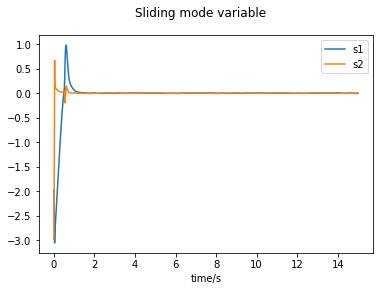

In [114]:
plt.suptitle('Sliding mode variable')
plt.plot(time_list, s1, label="s1")
plt.plot(time_list, s2, label="s2")
plt.xlabel('time/s')
plt.legend()

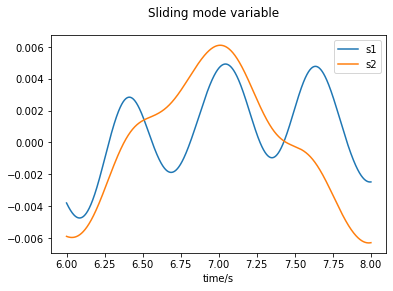

In [115]:
plt.suptitle('Sliding mode variable')
plt.plot(time_list[6000:8000], s1[6000:8000], label="s1")
plt.plot(time_list[6000:8000], s2[6000:8000], label="s2")
plt.xlabel('time/s')
plt.legend()

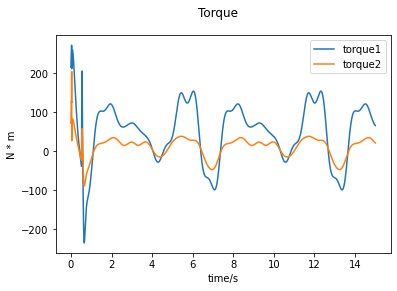

In [116]:
plt.suptitle('Torque')
plt.plot(time_list, torque1_list, label="torque1")
plt.plot(time_list, torque2_list, label="torque2")
plt.xlabel('time/s')
plt.ylabel('N * m')
plt.legend()

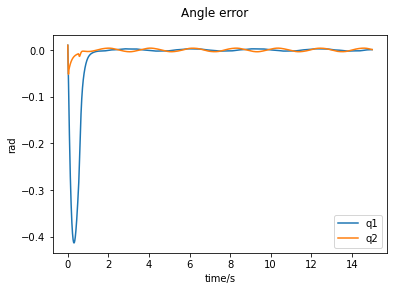

In [117]:
plt.suptitle('Angle error')
plt.plot(time_list, q1_list, label="q1")
plt.plot(time_list, q2_list, label="q2")
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

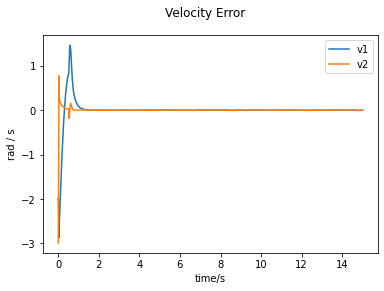

In [118]:
plt.suptitle('Velocity Error')
plt.plot(time_list, q1_dot_list, label="v1")
plt.plot(time_list, q2_dot_list, label="v2")
plt.xlabel('time/s')
plt.ylabel('rad / s')
plt.legend()